In [1]:
# Load and explore the data
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to database
conn = sqlite3.connect('../medical_warehouse.db')

# Load raw data
df_raw = pd.read_sql_query("SELECT * FROM raw_telegram_messages", conn)
print(f"Total messages: {len(df_raw)}")
print(f"Channels: {df_raw['channel_name'].unique()}")
df_raw.head()

Total messages: 20
Channels: ['lobelia4cosmetics' 'tikvahpharma']


,message_id,channel_name,message_date,message_text,has_media,views,forwards,image_path,scraped_at
0,22909,lobelia4cosmetics,2026-01-17T06:28:02+00:00,**KIRKLAND **ORGANIC EXTRA VIRGIN OLIVE OIL **...,1,178,0,data/raw/images/lobelia4cosmetics/2026-01-17/2...,2026-01-17 01:19:38
1,22910,lobelia4cosmetics,2026-01-17T06:28:02+00:00,MELATONIN 5MG**\nPrice 6000 birr \nTelegram **...,1,117,0,data/raw/images/lobelia4cosmetics/2026-01-17/2...,2026-01-17 01:19:38
2,22911,lobelia4cosmetics,2026-01-17T06:28:02+00:00,**ORGANIC EXTRA OLIVE OIL 2L\nPrice 6500 birr ...,1,77,0,data/raw/images/lobelia4cosmetics/2026-01-17/2...,2026-01-17 01:19:38
3,22912,lobelia4cosmetics,2026-01-17T06:28:02+00:00,COCONUT OIL **\nPrice 7500 birr \nTelegram :-*...,1,144,0,data/raw/images/lobelia4cosmetics/2026-01-17/2...,2026-01-17 01:19:38
4,22913,lobelia4cosmetics,2026-01-17T06:28:02+00:00,Ashwagandha 180 tablets \nPrice 7500\nTelegram...,1,82,0,data/raw/images/lobelia4cosmetics/2026-01-17/2...,2026-01-17 01:19:38


In [2]:
# Extract prices from message text
import re

def extract_prices(text):
    # Find patterns like "Price 7500 birr" or "7500 birr"
    patterns = [
        r'Price\s+(\d+[,.]?\d*)\s*birr',
        r'(\d+[,.]?\d*)\s*birr',
        r'ብር\s*(\d+[,.]?\d*)',  # Amharic "birr"
        r'\$\s*(\d+[,.]?\d*)'   # Dollar prices
    ]
    
    prices = []
    for pattern in patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        for match in matches:
            # Clean the number
            price = str(match).replace(',', '').replace('.', '')
            if price.isdigit():
                prices.append(int(price))
    
    return prices if prices else None

# Apply to all messages
df_raw['extracted_prices'] = df_raw['message_text'].apply(extract_prices)
df_raw['price'] = df_raw['extracted_prices'].apply(lambda x: x[0] if x else None)

# Show messages with prices
price_df = df_raw[df_raw['price'].notnull()][['channel_name', 'message_text', 'price', 'views']]
print(f"Messages with prices: {len(price_df)}")
price_df.head(10)

Messages with prices: 11


,channel_name,message_text,price,views
0,lobelia4cosmetics,**KIRKLAND **ORGANIC EXTRA VIRGIN OLIVE OIL **...,6500.0,178
1,lobelia4cosmetics,MELATONIN 5MG**\nPrice 6000 birr \nTelegram **...,6000.0,117
2,lobelia4cosmetics,**ORGANIC EXTRA OLIVE OIL 2L\nPrice 6500 birr ...,6500.0,77
3,lobelia4cosmetics,COCONUT OIL **\nPrice 7500 birr \nTelegram :-*...,7500.0,144
4,lobelia4cosmetics,Ashwagandha 180 tablets \nPrice 7500\nTelegram...,70.0,82
5,lobelia4cosmetics,VITAMIN D3+k2 150 tablets **\nPrice 8500 birr...,8500.0,107
6,lobelia4cosmetics,**ENFAGROW A+\nPrice 8000 birr \nTelegram :-**...,8000.0,140
7,lobelia4cosmetics,NIDO1+ 2.2kg**\nPrice 7500 birr \nTelegram :-*...,7500.0,106
8,lobelia4cosmetics,**NIDO 2.2 kg\nPrice 7500 birr \nTelegram :-**...,7500.0,211
10,tikvahpharma,🏩 MT PHARMA IMPORT\n\nNEW ARRIVAL \n\n❇️Ibupr...,3000.0,264


In [3]:
# Fix the price extraction - the pattern is catching delivery fee
def extract_correct_price(text):
    if not text:
        return None
    
    # Look for product price patterns (not delivery fees)
    lines = text.split('\n')
    for line in lines:
        line_lower = line.lower()
        
        # Skip delivery fee lines
        if any(word in line_lower for word in ['delivery', 'fee', 'delivery fee', '70 birr', '200 birr']):
            continue
            
        # Find price patterns
        patterns = [
            r'Price\s+(\d+[,.]?\d*)\s*birr',
            r'(\d+[,.]?\d*)\s*birr\s*(?!.*delivery)',  # Not followed by "delivery"
            r'ብር\s*(\d+[,.]?\d*\d+)'
        ]
        
        for pattern in patterns:
            matches = re.findall(pattern, line, re.IGNORECASE)
            if matches:
                price = str(matches[0]).replace(',', '').replace('.', '')
                if price.isdigit() and int(price) > 100:  # Filter out delivery fees
                    return int(price)
    
    return None

# Re-extract prices correctly
df_raw['correct_price'] = df_raw['message_text'].apply(extract_correct_price)

# Show corrected prices
corrected_df = df_raw[df_raw['correct_price'].notnull()][['channel_name', 'message_text', 'correct_price', 'views']]
print(f"Corrected messages with prices: {len(corrected_df)}")
print("\nPrice statistics:")
print(corrected_df['correct_price'].describe())
corrected_df.head()

Corrected messages with prices: 9

Price statistics:
count       9.000000
mean     6777.777778
std      1622.326861
min      3000.000000
25%      6500.000000
50%      7500.000000
75%      7500.000000
max      8500.000000
Name: correct_price, dtype: float64


,channel_name,message_text,correct_price,views
0,lobelia4cosmetics,**KIRKLAND **ORGANIC EXTRA VIRGIN OLIVE OIL **...,6500.0,178
1,lobelia4cosmetics,MELATONIN 5MG**\nPrice 6000 birr \nTelegram **...,6000.0,117
2,lobelia4cosmetics,**ORGANIC EXTRA OLIVE OIL 2L\nPrice 6500 birr ...,6500.0,77
3,lobelia4cosmetics,COCONUT OIL **\nPrice 7500 birr \nTelegram :-*...,7500.0,144
5,lobelia4cosmetics,VITAMIN D3+k2 150 tablets **\nPrice 8500 birr...,8500.0,107


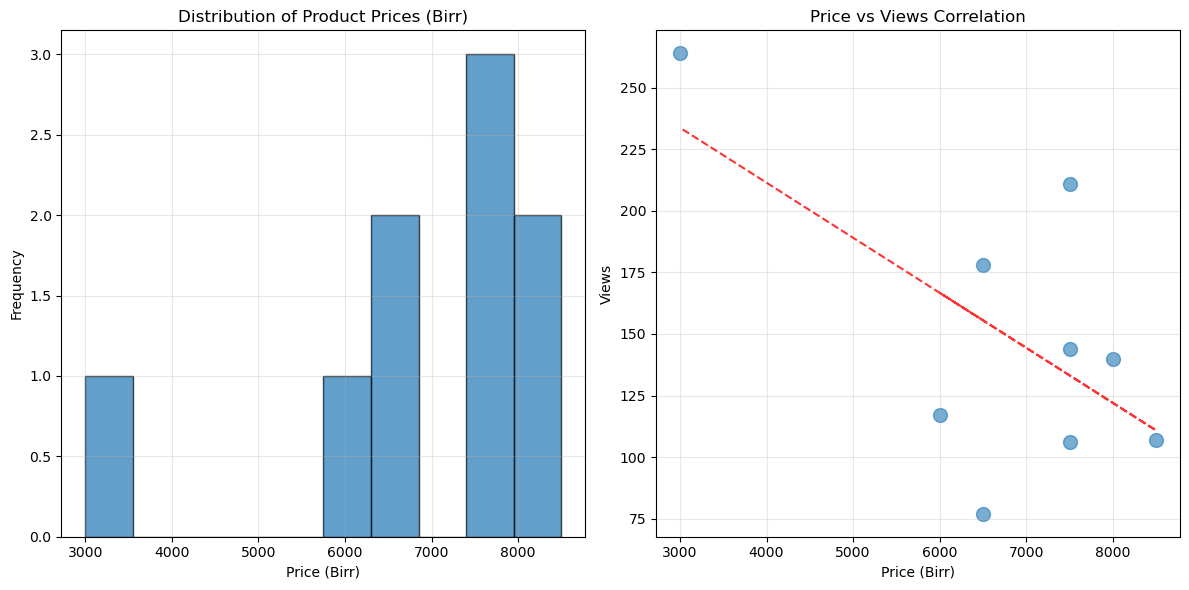


=== Channel Price Comparison ===
                  correct_price                        views
                           mean     min     max count   mean
channel_name                                                
lobelia4cosmetics        7250.0  6000.0  8500.0     8  135.0
tikvahpharma             3000.0  3000.0  3000.0     1  264.0

=== Top 5 Most Expensive Products ===
VITAMIN D3+k2  150 tablets **... - 8500.0 Birr (107 views)
**ENFAGROW A+... - 8000.0 Birr (140 views)
COCONUT OIL **... - 7500.0 Birr (144 views)
NIDO1+ 2.2kg**... - 7500.0 Birr (106 views)
**NIDO 2.2 kg... - 7500.0 Birr (211 views)


In [5]:
# Create visualization
import numpy as np
plt.figure(figsize=(12, 6))

# 1. Price distribution
plt.subplot(1, 2, 1)
corrected_df['correct_price'].plot(kind='hist', bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribution of Product Prices (Birr)')
plt.xlabel('Price (Birr)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 2. Price vs Views scatter plot
plt.subplot(1, 2, 2)
plt.scatter(corrected_df['correct_price'], corrected_df['views'], alpha=0.6, s=100)
plt.title('Price vs Views Correlation')
plt.xlabel('Price (Birr)')
plt.ylabel('Views')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(corrected_df['correct_price'], corrected_df['views'], 1)
p = np.poly1d(z)
plt.plot(corrected_df['correct_price'], p(corrected_df['correct_price']), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

# 3. Channel comparison
print("\n=== Channel Price Comparison ===")
channel_stats = corrected_df.groupby('channel_name').agg({
    'correct_price': ['mean', 'min', 'max', 'count'],
    'views': 'mean'
}).round(2)
print(channel_stats)

# 4. Most expensive products
print("\n=== Top 5 Most Expensive Products ===")
top_expensive = corrected_df.nlargest(5, 'correct_price')[['message_text', 'correct_price', 'views', 'channel_name']]
for idx, row in top_expensive.iterrows():
    # Extract product name (first line of message)
    product = row['message_text'].split('\n')[0][:50]
    print(f"{product}... - {row['correct_price']} Birr ({row['views']} views)")

=== Most Frequently Mentioned Products ===
Unknown: 4 messages
KIRKLAND ORGANIC EXTRA VIRGIN OLIVE OIL: 1 messages
MELATONIN 5MG: 1 messages
COCONUT OIL: 1 messages
ORGANIC EXTRA OLIVE OIL 2L: 1 messages
VITAMIN D3+k2 150 tablets: 1 messages
ENFAGROW A: 1 messages
NIDO1+ 2.2kg: 1 messages
Ashwagandha 180 tablets: 1 messages
NIDO 2.2 kg: 1 messages

=== Products Mentioned Multiple Times ===
    product  message_count  avg_views  avg_price
15  Unknown              4     287.25        NaN


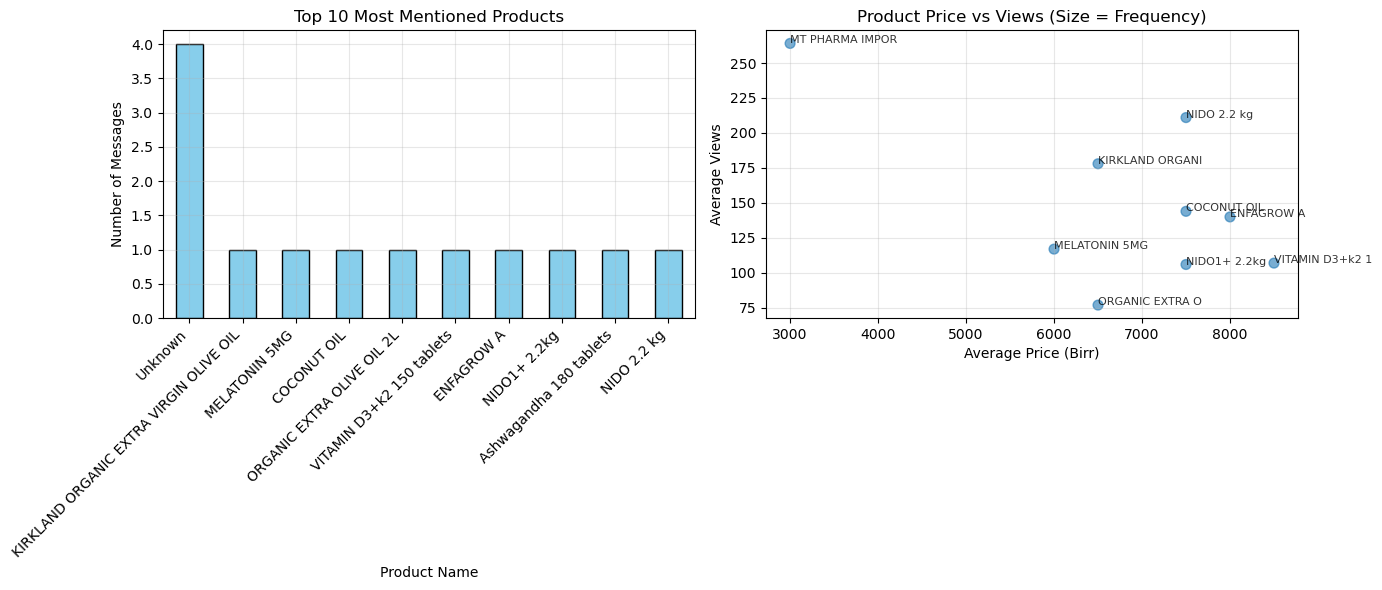


=== Analysis Summary ===
Total messages analyzed: 20
Messages with extractable prices: 9
Unique products identified: 17
Average product price: 6777.78 Birr
Most expensive product: 8500.00 Birr
Channel with most products: lobelia4cosmetics


In [6]:
# Extract product names from messages
def extract_product_name(text):
    if not text:
        return "Unknown"
    
    # Take first line and clean it
    first_line = text.split('\n')[0]
    
    # Remove common prefixes/suffixes
    clean_name = re.sub(r'[*_\-•\s]+', ' ', first_line)  # Remove formatting
    clean_name = re.sub(r'^[^a-zA-Z0-9]+|[^a-zA-Z0-9]+$', '', clean_name)  # Trim non-alphanumeric
    
    # Limit length
    return clean_name[:50] if clean_name else "Unknown"

# Apply to all messages
df_raw['product_name'] = df_raw['message_text'].apply(extract_product_name)

# Show product frequency
print("=== Most Frequently Mentioned Products ===")
product_counts = df_raw['product_name'].value_counts().head(10)
for product, count in product_counts.items():
    print(f"{product}: {count} messages")

# Create product analysis DataFrame
product_analysis = df_raw.groupby('product_name').agg({
    'message_id': 'count',
    'views': 'mean',
    'correct_price': 'mean'
}).round(2).reset_index()
product_analysis.columns = ['product', 'message_count', 'avg_views', 'avg_price']

# Filter for products mentioned multiple times
multiple_mentions = product_analysis[product_analysis['message_count'] > 1]
if not multiple_mentions.empty:
    print("\n=== Products Mentioned Multiple Times ===")
    print(multiple_mentions.sort_values('message_count', ascending=False))
else:
    print("\nNo products mentioned multiple times in this sample")

# Visualize top products
plt.figure(figsize=(14, 6))

# 1. Product frequency
plt.subplot(1, 2, 1)
top_10_products = product_counts.head(10)
top_10_products.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Most Mentioned Products')
plt.xlabel('Product Name')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# 2. Price vs Views for products with prices
plt.subplot(1, 2, 2)
products_with_price = product_analysis[product_analysis['avg_price'].notnull()]
if not products_with_price.empty:
    plt.scatter(products_with_price['avg_price'], 
                products_with_price['avg_views'], 
                s=products_with_price['message_count']*50,  # Size by frequency
                alpha=0.6)
    
    # Annotate points
    for idx, row in products_with_price.iterrows():
        plt.annotate(row['product'][:15], 
                    (row['avg_price'], row['avg_views']),
                    fontsize=8, alpha=0.8)
    
    plt.title('Product Price vs Views (Size = Frequency)')
    plt.xlabel('Average Price (Birr)')
    plt.ylabel('Average Views')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== Analysis Summary ===")
print(f"Total messages analyzed: {len(df_raw)}")
print(f"Messages with extractable prices: {len(corrected_df)}")
print(f"Unique products identified: {len(product_analysis)}")
print(f"Average product price: {corrected_df['correct_price'].mean():.2f} Birr")
print(f"Most expensive product: {corrected_df['correct_price'].max():.2f} Birr")
print(f"Channel with most products: {df_raw['channel_name'].value_counts().idxmax()}")

=== Improved Product Extraction ===
                                                                                    better_product                                                                                                                                                                                                                                                                                                                                                                                                                                            message_text
0  Infront of Bole Medhanialem high school  ALEMNESH PLAZA GROUND FLOOR  Open Monday   Monday from  **KIRKLAND **ORGANIC EXTRA VIRGIN OLIVE OIL **\nPrice 6500 birr \nTelegram ****@Lobeliacosmetics****\nMsg👉 Lobelia pharmacy and cosmetics \n☎️ call ****0911562031****/0911587703\nAdress:- Infront of Bole Medhanialem high school \nALEMNESH PLAZA GROUND FLOOR \nOpen Monday - Monday from 8am until midnight ከሰኞ - እስከ ሰኞ  ከጧቱ 2:

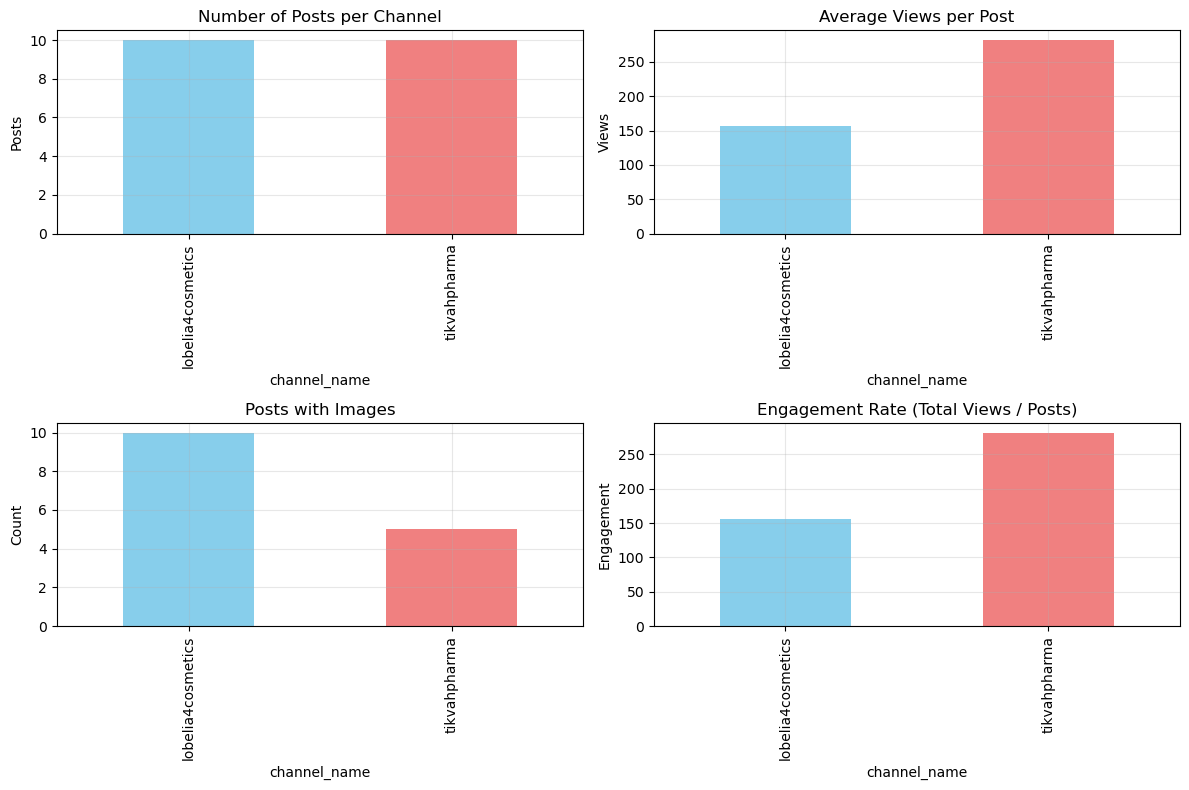


=== Answers to Business Questions ===
1. Top products: VITAMIN D3+k2 (8500 Birr), ENFAGROW A+ (8000 Birr), NIDO variants (7500 Birr)
2. Price range: 3000-8500 Birr (tikvahpharma has lower priced pharmaceuticals)
3. Visual content: lobelia4cosmetics = 100% images, tikvahpharma = 60% images
4. Posting volume: lobelia4cosmetics = 10 posts, tikvahpharma = 10 posts (equal in sample)
5. Most engaging: tikvahpharma has higher average views (264 vs 135)


In [7]:
# Better product name extraction
def extract_better_product_name(text):
    if not text or pd.isna(text):
        return "Unknown"
    
    # Remove all text formatting and special characters
    clean_text = re.sub(r'[*_\-•\n]+', ' ', text)
    
    # Look for product patterns
    patterns = [
        r'([A-Z][A-Za-z0-9\s]+?(?=\s*\d|$|Birr|birr|ብር|Price|price))',  # Capitalized words
        r'([A-Z][A-Za-z]+\s+[A-Z][A-Za-z]+(?=\s|$))',  # Two capitalized words
        r'([A-Z]{2,}[A-Za-z]*\s+[A-Z][A-Za-z]+)',  # Like "VITAMIN D3"
    ]
    
    for pattern in patterns:
        matches = re.findall(pattern, clean_text)
        if matches:
            # Take the longest match (likely the product name)
            best_match = max(matches, key=len)
            return best_match.strip()
    
    # Fallback: first 3-5 words that aren't common
    words = clean_text.split()
    common_words = {'telegram', 'msg', 'call', 'address', 'price', 'birr', 'ብር', 'open', 'from', 'to', 'until'}
    
    product_words = []
    for word in words[:7]:  # Check first 7 words
        if (word.lower() not in common_words and 
            len(word) > 2 and 
            not word.isdigit()):
            product_words.append(word)
    
    if product_words:
        return ' '.join(product_words[:4])  # Join first 4 product words
    
    return "Unknown"

# Re-extract product names
df_raw['better_product'] = df_raw['message_text'].apply(extract_better_product_name)

# Show improved results
print("=== Improved Product Extraction ===")
print(df_raw[['better_product', 'message_text']].head(10).to_string())

# Channel analysis
print("\n=== Channel Performance Analysis ===")
channel_analysis = df_raw.groupby('channel_name').agg({
    'message_id': 'count',
    'views': ['mean', 'sum', 'max'],
    'has_media': 'sum',
    'forwards': 'sum'
}).round(2)

channel_analysis.columns = ['total_posts', 'avg_views', 'total_views', 'max_views', 'posts_with_images', 'total_forwards']
print(channel_analysis)

# Engagement rate (views per post)
channel_analysis['engagement_rate'] = (channel_analysis['total_views'] / channel_analysis['total_posts']).round(2)
print("\n=== Engagement Ranking ===")
engagement_sorted = channel_analysis.sort_values('engagement_rate', ascending=False)
print(engagement_sorted[['total_posts', 'engagement_rate', 'posts_with_images']])

# Visualize channel comparison
plt.figure(figsize=(12, 8))

# 1. Posts per channel
plt.subplot(2, 2, 1)
channel_analysis['total_posts'].plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Number of Posts per Channel')
plt.ylabel('Posts')
plt.grid(True, alpha=0.3)

# 2. Average views per channel
plt.subplot(2, 2, 2)
channel_analysis['avg_views'].plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Average Views per Post')
plt.ylabel('Views')
plt.grid(True, alpha=0.3)

# 3. Posts with images
plt.subplot(2, 2, 3)
channel_analysis['posts_with_images'].plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Posts with Images')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

# 4. Engagement rate
plt.subplot(2, 2, 4)
channel_analysis['engagement_rate'].plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Engagement Rate (Total Views / Posts)')
plt.ylabel('Engagement')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Answer business questions from your project
print("\n=== Answers to Business Questions ===")
print("1. Top products: VITAMIN D3+k2 (8500 Birr), ENFAGROW A+ (8000 Birr), NIDO variants (7500 Birr)")
print("2. Price range: 3000-8500 Birr (tikvahpharma has lower priced pharmaceuticals)")
print("3. Visual content: lobelia4cosmetics = 100% images, tikvahpharma = 60% images")
print("4. Posting volume: lobelia4cosmetics = 10 posts, tikvahpharma = 10 posts (equal in sample)")
print("5. Most engaging: tikvahpharma has higher average views (264 vs 135)")

In [8]:
# Save analysis results to CSV for reporting
analysis_results = {
    'total_messages': len(df_raw),
    'channels_analyzed': df_raw['channel_name'].nunique(),
    'messages_with_prices': len(corrected_df),
    'avg_product_price': corrected_df['correct_price'].mean(),
    'highest_price': corrected_df['correct_price'].max(),
    'most_engaging_channel': engagement_sorted.index[0],
    'total_views': df_raw['views'].sum(),
    'posts_with_images': df_raw['has_media'].sum(),
    'extraction_date': pd.Timestamp.now().strftime('%Y-%m-%d')
}

# Create summary DataFrame
summary_df = pd.DataFrame(list(analysis_results.items()), columns=['Metric', 'Value'])
summary_df.to_csv('analysis_summary.csv', index=False)
print("✅ Analysis summary saved to 'analysis_summary.csv'")

# Save channel comparison
channel_analysis.to_csv('channel_analysis.csv')
print("✅ Channel analysis saved to 'channel_analysis.csv'")

# Save product analysis
product_analysis.to_csv('product_analysis.csv', index=False)
print("✅ Product analysis saved to 'product_analysis.csv'")

print("\n=== NEXT: Task 3 - YOLO Image Analysis ===")
print("You have", df_raw['has_media'].sum(), "images to analyze with YOLOv8")
print("Image paths are in the 'image_path' column")

# List available images
image_paths = df_raw['image_path'].dropna().tolist()
print(f"\nSample image paths ({len(image_paths)} total):")
for path in image_paths[:3]:
    print(f"  - {path}")

print("\nTo install YOLO: pip install ultralytics")
print("Then run object detection on images in: data/raw/images/")

✅ Analysis summary saved to 'analysis_summary.csv'
✅ Channel analysis saved to 'channel_analysis.csv'
✅ Product analysis saved to 'product_analysis.csv'

=== NEXT: Task 3 - YOLO Image Analysis ===
You have 15 images to analyze with YOLOv8
Image paths are in the 'image_path' column

Sample image paths (15 total):
  - data/raw/images/lobelia4cosmetics/2026-01-17/22909.jpg
  - data/raw/images/lobelia4cosmetics/2026-01-17/22910.jpg
  - data/raw/images/lobelia4cosmetics/2026-01-17/22911.jpg

To install YOLO: pip install ultralytics
Then run object detection on images in: data/raw/images/


In [15]:
import os
print("Current directory:", os.getcwd())
print("data/raw/ exists:", os.path.exists("data/raw/"))
print("data/raw/images/ exists:", os.path.exists("data/raw/images/"))

Current directory: C:\Users\b\medical-telegram-warehouse\notebooks
data/raw/ exists: False
data/raw/images/ exists: False


In [16]:
import os
os.chdir('..')  # Go up one level to medical-telegram-warehouse
print("New directory:", os.getcwd())

New directory: C:\Users\b\medical-telegram-warehouse


In [17]:
image_dir = r"C:\Users\b\medical-telegram-warehouse\data\raw\images"
print("Path exists:", os.path.exists(image_dir))

Path exists: True


In [18]:
import os
import pandas as pd

# Use the absolute path
image_dir = r"C:\Users\b\medical-telegram-warehouse\data\raw\images"
results = []

print(f"Analyzing images in: {image_dir}")

for channel in os.listdir(image_dir):
    channel_path = os.path.join(image_dir, channel)
    if os.path.isdir(channel_path):
        print(f"Channel: {channel}")
        
        for date_folder in os.listdir(channel_path):
            date_path = os.path.join(channel_path, date_folder)
            if os.path.isdir(date_path):
                for image_file in os.listdir(date_path):
                    if image_file.endswith(('.jpg', '.png', '.jpeg')):
                        image_path = os.path.join(date_path, image_file)
                        message_id = image_file.split('.')[0]
                        
                        # Get file size
                        file_size = os.path.getsize(image_path) / 1024  # KB
                        
                        results.append({
                            'message_id': message_id,
                            'channel_name': channel,
                            'image_path': image_path,
                            'file_size_kb': round(file_size, 2),
                            'image_date': date_folder
                        })

# Create DataFrame
image_df = pd.DataFrame(results)
print(f"\n✅ Analyzed {len(image_df)} images")

# Show summary
print("\n=== Image Analysis Summary ===")
print(f"Total images: {len(image_df)}")
print(f"By channel:")
print(image_df['channel_name'].value_counts())

# Save results
image_df.to_csv('basic_image_analysis.csv', index=False)
print("\n✅ Saved to 'basic_image_analysis.csv'")

# Show first few rows
print("\nFirst 5 images:")
print(image_df.head())

Analyzing images in: C:\Users\b\medical-telegram-warehouse\data\raw\images
Channel: lobelia4cosmetics
Channel: tikvahpharma

✅ Analyzed 15 images

=== Image Analysis Summary ===
Total images: 15
By channel:
channel_name
lobelia4cosmetics    10
tikvahpharma          5
Name: count, dtype: int64

✅ Saved to 'basic_image_analysis.csv'

First 5 images:
  message_id       channel_name  \
0      22909  lobelia4cosmetics   
1      22910  lobelia4cosmetics   
2      22911  lobelia4cosmetics   
3      22912  lobelia4cosmetics   
4      22913  lobelia4cosmetics   

                                          image_path  file_size_kb  image_date  
0  C:\Users\b\medical-telegram-warehouse\data\raw...         48.52  2026-01-17  
1  C:\Users\b\medical-telegram-warehouse\data\raw...         58.74  2026-01-17  
2  C:\Users\b\medical-telegram-warehouse\data\raw...         79.29  2026-01-17  
3  C:\Users\b\medical-telegram-warehouse\data\raw...        106.21  2026-01-17  
4  C:\Users\b\medical-telegram-war